In [33]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

import warnings
warnings.simplefilter('ignore')

### __Illustration of sine-cosine trafos__

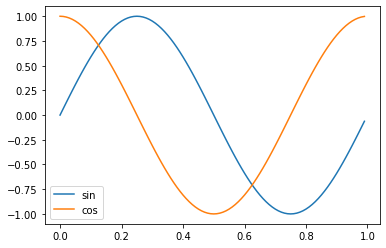

In [34]:
rcParams['figure.figsize'] = 6,4

X1 = np.linspace(0,1,50)
X = np.arange(0,1,0.01)

y_sin = np.sin(2 * np.pi*X)
y_cos = np.cos(2 * np.pi*X)

sns.lineplot(X,y_sin,label="sin")
sns.lineplot(X,y_cos,label="cos")

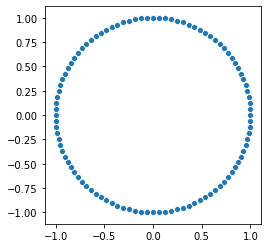

In [35]:
sns.scatterplot(y_sin, y_cos).set_aspect('equal')

### __Time transformations and final data cleaning__

In [36]:
file_path = '{}/nem-data/nemde_clean/df_DUID_CO2_mean.pkl'.format(os.environ['HOME'])
df_mean = pd.read_pickle(file_path)
df_mean = df_mean.sort_index()
df_mean = df_mean[df_mean.index >= dt.datetime(2009,9,1,0,0,0)] #minimum time of interconncector
df_mean.head()

,Price,CO2E_EMISSIONS_FACTOR
2009-09-01 00:00:00,21.64992,0.986067
2009-09-01 00:05:00,21.49293,0.976360
2009-09-01 00:10:00,21.48960,0.976889
2009-09-01 00:15:00,21.14641,1.032780
2009-09-01 00:20:00,20.94913,0.975655


In [37]:
#df_sub = df_mean[(df_mean.index > dt.datetime(2017,1,1))]
#print(df_sub.index.min())
#print(df_sub.index.max())
#df_sub = df_sub.sort_index()
#df_sub.head()

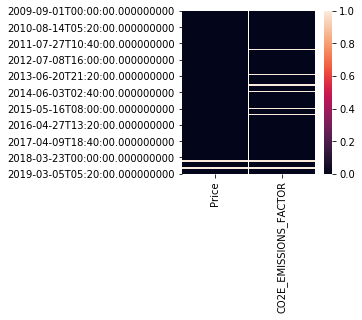

<Figure size 864x720 with 0 Axes>

In [38]:
from pylab import rcParams
rcParams['figure.figsize'] = 3,3

fig = sns.heatmap(df_mean.isna(), yticklabels=100000)
plt.figure(figsize=(12,10));

In [39]:
def time_columns(df):
    
    df.loc[:,"minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["weekday"] = np.where(df.index.weekday < 5, 0, 1)
    df["month"] = df.index.month
    df["year"] = df.index.year

    df['minute_sin'] = np.sin(2 * np.pi * df.loc[:,'minute']/60.0)
    df['minute_cos'] = np.cos(2 * np.pi * df.loc[:,'minute']/60.0)

    df['hour_sin'] = np.sin(2 * np.pi * df.loc[:,'hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.loc[:,'hour']/24.0)
    
    df['weekday_sin'] = np.sin(2 * np.pi * df.loc[:,'weekday']/7.0)
    
    df['month_sin'] = np.sin(2 * np.pi * df.loc[:,'month']/12.0)
    df['month_cos'] = np.cos(2 * np.pi * df.loc[:,'month']/12.0)
    
    df['year_sin'] = np.sin(2 * np.pi * df.loc[:,'year']/11.0)
    df['year_cos'] = np.cos(2 * np.pi * df.loc[:,'year']/11.0)
    
    

    df.drop(columns=["Price", "minute", "weekday", "hour", "month"], inplace=True)
    
    return df

In [40]:
def lag_horizon(df, lag, horizon):
    '''
    Returns dataset with additional features defined by lag and modified target defined by horizon
    lag=integer of how far back time series should look
    horizon=integer of how far into the future the model shall predict; horizon=0 means prediciton 1 step into future
    '''
    for i in range(1,lag+1):
        df['lag{}'.format(i)] = df.CO2E_EMISSIONS_FACTOR.shift(i)
    
    for i in range(1,horizon+2):
        df['horizon{}'.format(i-1)] = df.CO2E_EMISSIONS_FACTOR[lag+i:].shift(-i+1)
        
    return df

In [41]:
df_mean1 = time_columns(df_mean)
df_mean1.head()

,CO2E_EMISSIONS_FACTOR,year,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,year_sin,year_cos
2009-09-01 00:00:00,0.986067,2009,0.000000,1.000000e+00,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861
2009-09-01 00:05:00,0.976360,2009,0.500000,8.660254e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861
2009-09-01 00:10:00,0.976889,2009,0.866025,5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861
2009-09-01 00:15:00,1.032780,2009,1.000000,2.832769e-16,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861
2009-09-01 00:20:00,0.975655,2009,0.866025,-5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,-0.654861


In [42]:
df_mean2 = lag_horizon(df_mean1,12,0)
df_mean2.head(10)

,CO2E_EMISSIONS_FACTOR,year,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,year_sin,...,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,horizon0
2009-09-01 00:00:00,0.986067,2009,0.000000e+00,1.000000e+00,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:05:00,0.976360,2009,5.000000e-01,8.660254e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:10:00,0.976889,2009,8.660254e-01,5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:15:00,1.032780,2009,1.000000e+00,2.832769e-16,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:20:00,0.975655,2009,8.660254e-01,-5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,0.986067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:25:00,0.976360,2009,5.000000e-01,-8.660254e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,0.976360,0.986067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:30:00,0.976360,2009,5.665539e-16,-1.000000e+00,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,0.976889,0.976360,0.986067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:35:00,0.976360,2009,-5.000000e-01,-8.660254e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,1.032780,0.976889,0.976360,0.986067,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:40:00,0.976360,2009,-8.660254e-01,-5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,0.975655,1.032780,0.976889,0.976360,0.986067,NaN,NaN,NaN,NaN,NaN
2009-09-01 00:45:00,0.986980,2009,-1.000000e+00,-1.836970e-16,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,0.976360,0.975655,1.032780,0.976889,0.976360,0.986067,NaN,NaN,NaN,NaN


### __Introducing demand__

In [43]:
demand = pd.read_csv('{}/nem-data/demand.csv'.format(os.environ['HOME']), index_col=-1, parse_dates=True)
demand.drop(columns=["SETTLEMENTDATE", "I", "INTERVENTION"], inplace=True)
demand = demand[(demand.index >= df_mean2.index.min()) & (demand.index <= df_mean2.index.max())]

assert demand.index.min() == df_mean2.index.min()
assert demand.index.max() == df_mean2.index.max()

demand.head()

,TOTALDEMAND,AVAILABLEGENERATION
start-of-interval,,
2009-09-01 00:00:00,1667.12,2763.79779
2009-09-01 00:05:00,1657.52,2762.70982
2009-09-01 00:10:00,1650.15,2764.64186
2009-09-01 00:15:00,1630.66,2766.46786
2009-09-01 00:20:00,1628.96,2773.72786


In [44]:
print(demand.index.min())
print(demand.index.max())

print(df_mean2.index.min())
print(df_mean2.index.max())

2009-09-01 00:00:00
2019-08-01 03:55:00
2009-09-01 00:00:00
2019-08-01 03:55:00


In [45]:
len(pd.date_range(start=demand.index.min(), end=demand.index.max(), freq="5min"))

1042896

In [46]:
test1 = demand.groupby(demand.index).agg({"TOTALDEMAND":"count","AVAILABLEGENERATION":"count"})
print(test1.TOTALDEMAND.value_counts())
print(test1.AVAILABLEGENERATION.value_counts())

test2 = demand.groupby(demand.index).agg({"TOTALDEMAND": "nunique","AVAILABLEGENERATION":"nunique"})
print(test2.TOTALDEMAND.value_counts()) 
print(test2.AVAILABLEGENERATION.value_counts())

#all TOTALDEMANDS and AVAILABLEGENERATION are unique

1    1002932
2      39964
Name: TOTALDEMAND, dtype: int64
1    1002932
2      39964
Name: AVAILABLEGENERATION, dtype: int64
1    1042896
Name: TOTALDEMAND, dtype: int64
1    1042896
Name: AVAILABLEGENERATION, dtype: int64


In [47]:
demand = demand.groupby(demand.index).mean()

In [48]:
df_mean2["demand"] = demand.TOTALDEMAND
df_mean2["demand_capacity"] = demand.TOTALDEMAND/demand.AVAILABLEGENERATION

In [49]:
print(df_mean2.shape)
df_mean2.head()

(1042896, 26)


,CO2E_EMISSIONS_FACTOR,year,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,year_sin,...,lag6,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity
2009-09-01 00:00:00,0.986067,2009,0.000000,1.000000e+00,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1667.12,0.603199
2009-09-01 00:05:00,0.976360,2009,0.500000,8.660254e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657.52,0.599962
2009-09-01 00:10:00,0.976889,2009,0.866025,5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.15,0.596877
2009-09-01 00:15:00,1.032780,2009,1.000000,2.832769e-16,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1630.66,0.589438
2009-09-01 00:20:00,0.975655,2009,0.866025,-5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1628.96,0.587282


### __Introducing interconnectors__

In [50]:
interconnectors = pd.read_csv('{}/nem-data/interconnectors.csv'.format(os.environ['HOME']), index_col=-1, parse_dates=True)
interconnectors.drop(columns=["SETTLEMENTDATE", "I", "INTERCONNECTORID"], inplace=True)
interconnectors = interconnectors[(interconnectors.index >= df_mean2.index.min()) & (interconnectors.index <= df_mean2.index.max())]

assert interconnectors.index.min() == df_mean2.index.min()
assert interconnectors.index.max() == df_mean2.index.max()

interconnectors.head()

,MWFLOW
start-of-interval,
2009-09-01 00:00:00,302.86
2009-09-01 00:05:00,300.00
2009-09-01 00:10:00,290.52
2009-09-01 00:15:00,260.75
2009-09-01 00:20:00,256.98


In [51]:
print(interconnectors.shape)
print(interconnectors.index.min())
print(interconnectors.index.max())

(1084876, 1)
2009-09-01 00:00:00
2019-08-01 03:55:00


In [52]:
interconnectors.groupby(interconnectors.index).agg({"MWFLOW":"nunique"}).MWFLOW.value_counts()

1    1004400
2      38496
Name: MWFLOW, dtype: int64

In [53]:
interconnectors = interconnectors.groupby(interconnectors.index).mean()
interconnectors.shape

(1042896, 1)

In [54]:
df_mean2["interconnector"] = interconnectors.MWFLOW
df_mean2.head()

,CO2E_EMISSIONS_FACTOR,year,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,year_sin,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2009-09-01 00:00:00,0.986067,2009,0.000000,1.000000e+00,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1667.12,0.603199,302.86
2009-09-01 00:05:00,0.976360,2009,0.500000,8.660254e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657.52,0.599962,300.00
2009-09-01 00:10:00,0.976889,2009,0.866025,5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.15,0.596877,290.52
2009-09-01 00:15:00,1.032780,2009,1.000000,2.832769e-16,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1630.66,0.589438,260.75
2009-09-01 00:20:00,0.975655,2009,0.866025,-5.000000e-01,0.0,1.0,0.0,-1.0,-1.836970e-16,-0.75575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1628.96,0.587282,256.98


In [55]:
#df_mean2.iloc[15:30,9:]

In [56]:
def correct_timedelta(df, time_diff):
    '''
    df.index must be DateTimeIndex
    Returns two lists
    df=table_of_interest
    col="column_of_interest"
    time_diff=time_diff in seconds as int
    '''
    lst = []
    lst_i = []
    count = 0
    for i in df.index:
        count += 1
        if count >= len(df):
            break
        delta = abs(df.index[count] - df.index[count-1])
        if int(delta.total_seconds()) != int(time_diff):
            lst.append(("from index {} on, it has been {} s or {} h.".format(count-1,int(delta.total_seconds()),(int(delta.total_seconds()/3600)))))
            lst_i.append((df.index[count-1],int(delta.total_seconds())))
    return lst, lst_i

In [57]:
lst, lst_i = correct_timedelta(df_mean2, 300)

In [58]:
len(lst)

0

In [59]:
print(df_mean2.index.min())
print(df_mean2.index.max())

2009-09-01 00:00:00
2019-08-01 03:55:00


In [60]:
print(df_mean2.shape)
df_mean2.isna().any()

(1042896, 27)


CO2E_EMISSIONS_FACTOR     True
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
weekday_sin              False
month_sin                False
month_cos                False
year_sin                 False
year_cos                 False
lag1                      True
lag2                      True
lag3                      True
lag4                      True
lag5                      True
lag6                      True
lag7                      True
lag8                      True
lag9                      True
lag10                     True
lag11                     True
lag12                     True
horizon0                  True
demand                   False
demand_capacity          False
interconnector           False
dtype: bool

In [61]:
file_path = '{}/nem-data/nemde_clean/df_dirty_interconnectors.pkl'.format(os.environ['HOME'])
pd.to_pickle(df_mean2, file_path)

In [62]:
df_mean3 = df_mean2.dropna()

In [63]:
print(df_mean3.shape)
df_mean3.isna().any()

(807149, 27)


CO2E_EMISSIONS_FACTOR    False
year                     False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
weekday_sin              False
month_sin                False
month_cos                False
year_sin                 False
year_cos                 False
lag1                     False
lag2                     False
lag3                     False
lag4                     False
lag5                     False
lag6                     False
lag7                     False
lag8                     False
lag9                     False
lag10                    False
lag11                    False
lag12                    False
horizon0                 False
demand                   False
demand_capacity          False
interconnector           False
dtype: bool

In [64]:
file_path = '{}/nem-data/nemde_clean/df_clean_interconnectors.pkl'.format(os.environ['HOME'])
pd.to_pickle(df_mean3, file_path)